### 作業
請嘗試使用 keras 來定義一個直接預測 15 個人臉關鍵點坐標的檢測網路，以及適合這個網路的 loss function


Hint: 參考前面的電腦視覺深度學習基礎

### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [51]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96 ,1)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data.iloc[:, :-1].to_numpy()

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
DATA_ROOT = "Facial_Keypoints_Detection"
training_file = os.path.join(DATA_ROOT,"training.csv" )
imgs_train, points_train = load_data(dirname = training_file)
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96, 1) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras import backend as K
from keras import layers
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Lambda

Using TensorFlow backend.


In [5]:
def InceptionV1_block(x, specs,channel_axis, name):
    (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))
    
    '''Branch_0'''
    branch_0 = Conv2d_bn(x, br0[0], (1, 1), name=name+"_Branch_0")

    '''Branch_1'''    
    branch_1 = Conv2d_bn(x, br1[0], (1, 1), name=name+"_Branch_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (3, 3), name=name+"_Branch_1_1")

    '''Branch_2'''
    branch_2 = Conv2d_bn(x, br2[0], (1, 1), name=name+"_Branch_2")
    branch_2 = Conv2d_bn(branch_2, br2[1], (3, 3), name=name+"_Branch_2_1")    

    '''Branch_3'''
    branch_3 = MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding='same', name=name+"_Branch_3")(branch_2)
    branch_3 = Conv2d_bn(branch_3, br3[0], (1, 1), name=name+"_Branch_3_1")        
    
    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name=name+"_Concatenated")
    return x

In [6]:
def InceptionV3_block(x, specs,channel_axis, name):
    (br0, br1, br2, br3) = specs   # ((64,), (96,128), (16,32), (32,))
    branch_0 = Conv2d_bn(x, br0[0], (1, 1), name=name+"_Branch_0")

    branch_1 = Conv2d_bn(x, br1[0], (1, 1), name=name+"_Branch_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (1, 3), name=name+"_Branch_1_1")
    branch_1 = Conv2d_bn(branch_1, br1[1], (3, 1), name=name+"_Branch_1_2")

    '''Branch_2'''
    branch_2 = Conv2d_bn(x, br2[0], (1, 1), name=name+"_Branch_2")
    branch_2 = Conv2d_bn(branch_2, br2[1], (3, 1), name=name+"_Branch_2_1")    
    branch_2 = Conv2d_bn(branch_2, br2[1], (1, 3), name=name+"_Branch_2_2")    
    
    '''Branch_3'''
    branch_3 = MaxPooling2D(pool_size=(3, 3), strides=(1,1), padding='same', name=name+"_Branch_3")(branch_2)
    branch_3 = Conv2d_bn(branch_3, br3[0], (1, 1), name=name+"_Branch_3_1")        

    x = layers.concatenate(
        [branch_0, branch_1, branch_2, branch_3],
        axis=channel_axis,
        name=name+"_Concatenated")
    return x

In [7]:
def Conv2d_bn(x,filters,kernel_size,padding='same',strides=(1, 1),normalizer=True,activation='relu',name=None):
    if name is not None:
        conv_name = name + '_conv'
        bn_name = name + '_bn'
        act_name = name + '_act'
    else:
        conv_name = None
        bn_name = None
        act_name = None
    if K.image_data_format() == 'channels_first':
        bn_axis = 1
    else:
        bn_axis = 3
    x = Conv2D(
            filters, kernel_size,
            strides=strides, padding=padding,
            use_bias=False, name=conv_name)(x)
    if normalizer:
        x = BatchNormalization(axis=bn_axis, scale=False, name=bn_name)(x)
    if activation:
        x = Activation(activation, name=act_name)(x)
    return x

In [8]:
def VGG16_ResNet_Inception(include_top=True,input_tensor=None, input_shape=(224,224,1),
          pooling='max',classes=1000):
 
    img_input = Input(shape=input_shape)
    
    # Block 1    
    x = Conv2d_bn(img_input,64, (3, 3), activation='relu', padding='same', name='block1_conv1')
    x = Conv2d_bn(x,64, (3, 3), activation='relu', padding='same', name='block1_conv2')
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2d_bn(x,128, (3, 3), activation='relu', padding='same', name='block2_conv1')
    x = Conv2d_bn(x,128, (3, 3), activation='relu', padding='same', name='block2_conv2')
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_1')
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_2')
    x = InceptionV1_block(x, ((64,), (96,128), (16,32), (32,)), 3, 'Block_3')
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2d_bn(x,512, (3, 3), activation='relu', padding='same', name='block4_conv1')
    x = Conv2d_bn(x,512, (3, 3), activation='relu', padding='same', name='block4_conv2')
    x = Conv2d_bn(x,512, (3, 3), activation='relu', padding='same', name='block4_conv3')
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5 
    #為什麼要加InceptionV3_block 原因?
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_4')
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_5')
    x =InceptionV3_block(x, ((128,), (192,256), (32,64), (64,)), 3, 'Block_6')
    x =MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
       #可以提醒學員為什麼要加avg或是max
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
            
    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

   
    return model

In [9]:
# 定義人臉關鍵點檢測網路
model = VGG16_ResNet_Inception(include_top=False,input_shape=(96,96,1), classes=30)

model.summary()
print('Model深度：', len(model.layers))














__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
block1_conv1_conv (Conv2D)      (None, 96, 96, 64)   576         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 96, 96, 64)   192         block1_conv1_conv[0][0]          
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 96, 96, 64)   0           block1_conv1_bn[0][0]            
_________________________________________________________________________________________________

In [10]:
# 配置 loss funtion 和 optimizer
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [13]:
x_train = imgs_train.copy()
y_train = points_train.copy()

In [14]:
history = model.fit(x_train,y_train, validation_split = 0.2, shuffle=True, batch_size=256,epochs=20)



Train on 1712 samples, validate on 428 samples
Epoch 1/20
1712/1712 [==============================] - 42s 25ms/step - loss: 0.0398 - mean_absolute_error: 0.1673 - val_loss: 0.0515 - val_mean_absolute_error: 0.1835
Epoch 2/20
1712/1712 [==============================] - 12s 7ms/step - loss: 0.0309 - mean_absolute_error: 0.1482 - val_loss: 0.0676 - val_mean_absolute_error: 0.1999
Epoch 3/20
1712/1712 [==============================] - 11s 7ms/step - loss: 0.0274 - mean_absolute_error: 0.1411 - val_loss: 0.0713 - val_mean_absolute_error: 0.2030
Epoch 4/20
1712/1712 [==============================] - 11s 7ms/step - loss: 0.0258 - mean_absolute_error: 0.1392 - val_loss: 0.0601 - val_mean_absolute_error: 0.1923
Epoch 5/20
1712/1712 [==============================] - 11s 7ms/step - loss: 0.0250 - mean_absolute_error: 0.1382 - val_loss: 0.0589 - val_mean_absolute_error: 0.1908
Epoch 6/20
1712/1712 [==============================] - 11s 7ms/step - loss: 0.0245 - mean_absolute_error: 0.1374 -

Text(0, 0.5, 'MAE')

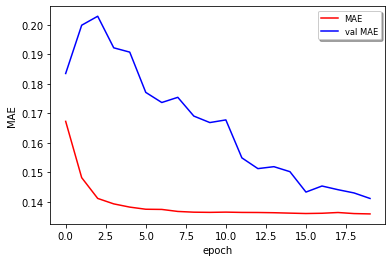

In [15]:
fig, ax = plt.subplots()
ax.plot(history.history["mean_absolute_error"], "red", label="MAE")
ax.plot(history.history["val_mean_absolute_error"], "blue", label="val MAE")
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
ax.set_xlabel("epoch")
ax.set_ylabel("MAE")